# 一、RAG介绍

如何使用没有被LLM训练过的数据来提高LLM性能？检索增强生成（RAG）是未来的发展方向，下面将解释一下它的含义和实际工作原理。

假设您有自己的数据集，例如来自公司的文本文档。如何让ChatGPT和其他LLM了解它并回答问题？

这可以通过四个步骤轻松完成：

**Embedding**：使用embedding模型对文档进行embedding操作，比如OpenAI的text-Embedding-ada-002或S-BERT（https://arxiv.org/abs/1908.10084）。
将文档的句子或单词块转换为数字向量。就向量之间的距离而言，彼此相似的句子应该很近，而不同的句子应该离得更远；

**Vector Store**：embedding文档之后就可以把它们存储在矢量存储中，比如ChromaDB、FAISS或Pinecone。矢量存储就像一个数据库，但顾名思义，它对矢量嵌入进行索引和存储，以实现快速检索和相似性搜索；

**Query**：既然你的文档已经嵌入并存储，当你向LLM提出特定问题时，它会embedding你的查询，并在向量存储中找到余弦相似度最接近你问题的句子；

**Answering Your Question**：一旦找到最接近的句子，它们就会被注入到Prompt中，就这样！LLM现在可以在没有经过任何再训练或微调的情况下回答有关数据的特定问题！

整体的架构，如下图所示：

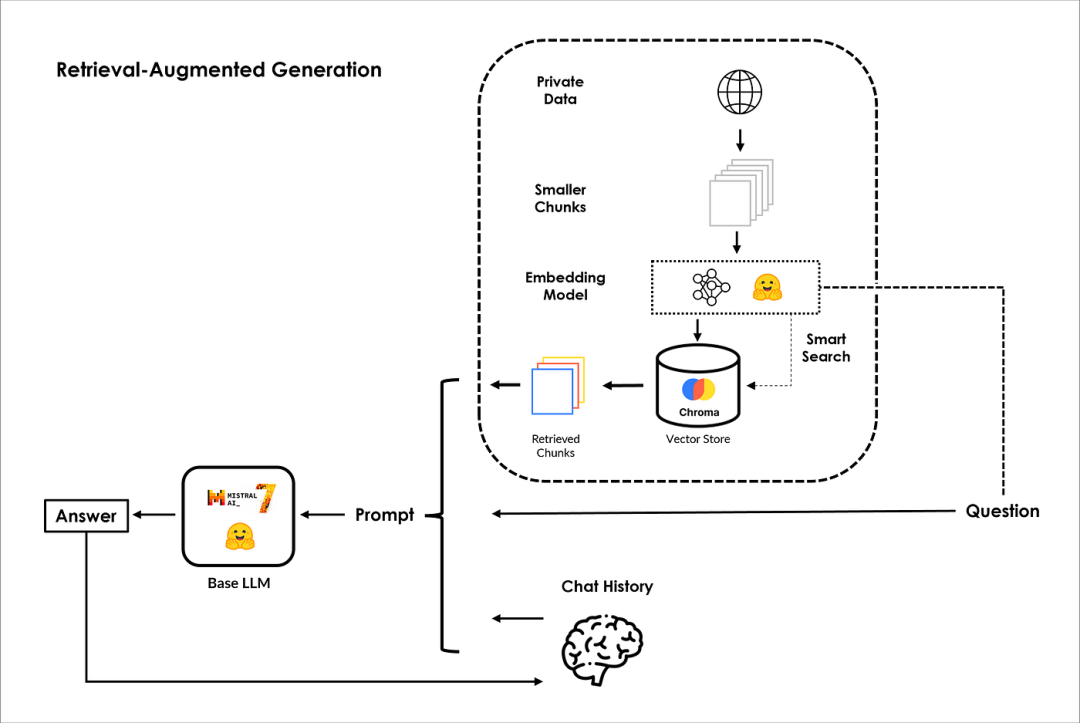

# 二、安装python环境以及相关的包

In [1]:
!pip install gradio --quiet
!pip install xformer --quiet
!pip install chromadb --quiet
!pip install langchain --quiet
!pip install accelerate --quiet
!pip install transformers --quiet
!pip install bitsandbytes --quiet
!pip install unstructured --quiet
!pip install sentence-transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 9.1 MB/s

# 三、导入相关包

In [2]:
import torch
import gradio as gr

from textwrap import fill
from IPython.display import Markdown, display

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    )

from langchain import PromptTemplate
from langchain import HuggingFacePipeline

from langchain.vectorstores import Chroma
from langchain.schema import AIMessage, HumanMessage
from langchain.memory import ConversationBufferMemory
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredMarkdownLoader, UnstructuredURLLoader
from langchain.chains import LLMChain, SimpleSequentialChain, RetrievalQA, ConversationalRetrievalChain

from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

import warnings
warnings.filterwarnings('ignore')

# 四、Mistral-7b模型介绍

Mistral-7B是由Mistral AI开源的，在多个benchmark上超过LLaMA2，如下图所示：



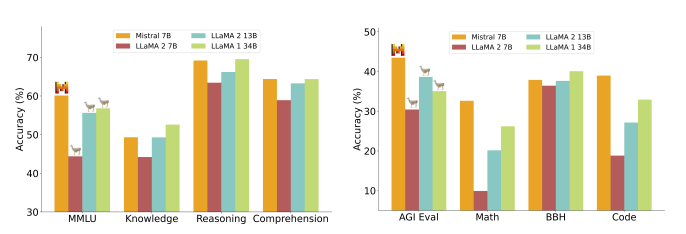

下面将使用Mistral AI开发的基础LLM Mistral-7b建立了一个文本生成Pipeline，对其进行量化、分词和生成参数进行配置：

**quantiation_config=BitsAndBytesConfig（…）**：这里，使用BitsAndBytesConfig定义量化配置。量化是一种用于降低深度学习模型的内存和计算需求的技术，通常通过使用更少的比特（在我们的情况下为4比特）来表示模型参数；

**tokenizer=AutoTokenizer.from_pretrained（…）**：这一行初始化Mistral-7b模型的tokenizer，允许您预处理输入到模型的文本数据；

**model=AutoModelForCausalLM.from_pretrained（…）**：这初始化了用于因果语言建模的预训练语言Mistral-7b模型。该模型配置有各种参数，包括先前设置的量化配置；

**generation_config=GenerationConfig.from_pretrained（…）**：为模型创建一个生成配置，指定各种与生成相关的设置，如令牌的最大数量、采样温度、top-p采样和重复惩罚；

**pipeline=pipeline（…）**：最后，使用pipeline函数创建一个文本生成管道。这个管道是为文本生成而设置的，它将预先训练的模型、标记器和生成配置作为输入。它被配置为返回全文输出。

In [3]:

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=quantization_config
)

generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.0001
generation_config.top_p = 0.95
generation_config.do_sample = True
generation_config.repetition_penalty = 1.15

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    generation_config=generation_config,
)

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

HuggingFacePipeline是一个允许您在本地运行Hugging Face模型的类，它用于访问和利用Hugging Face Model Hub上托管的各种预先训练的ML模型。在我们的案例中，我们将在LangChain环境中使用它作为本地包装器与Hugging Face模型进行交互。然而，当使用HuggingFacePipeline时，建议安装xformer（https://github.com/facebookresearch/xformers），以实现更高效的内存注意力实现。这就是我们在上面安装它的原因！

In [4]:
llm = HuggingFacePipeline(
    pipeline=pipeline,
    )

在将我们的基础LLM Mistral-7b连接到我们的私人数据之前。首先，让我们问一些一般性的问题。当然，它将根据在训练前获得的一般知识做出回应。

In [5]:
query = "Explain the difference between ChatGPT and open source LLMs in a couple of lines."
result = llm(
    query
)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Explain the difference between ChatGPT and open source LLMs in a couple of lines.</b>

<p>
ChatGPT is a proprietary model developed by OpenAI, while open source LLMs are models that are made available for anyone to use, modify, and distribute under an open-source license.</p>

看起来回答的不错！如果我们问它一个在预训练阶段没有遇到的问题，会发生什么？

In [6]:
query = "What is Hiberus GenIA Ecosystem?"
result = llm(
    query
)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>What is Hiberus GenIA Ecosystem?</b>

<p>
A: Hiberus GenIA Ecosystem refers to the entire ecosystem that supports and enables the development, deployment, and operation of Hiberus GenIA applications. This includes a wide range of components such as hardware, software, networking infrastructure, data storage, security, analytics, and more. The ecosystem also includes various tools and services that help developers build, test, deploy, and manage their applications.</p>

这不是预期的答案。GenIA生态系统甚至比这更酷，这是因为Mistral-7b LLM在预训练期间从未见过任何关于GenIA生态的信息。我保证在接下来的章节中引导您获得正确答案。

# 五、Embedding模型

在配置基础LLM之后，我们继续来配置embedding模型。正如您所知，每个文档都应该转换为embedding向量，以便使用用户的查询进行语义搜索，该查询也应该被embedding。为了实现这一点，我们将利用阿里巴巴大摩学院预训练并在Hugging Face上开源的embedding模型GTE（https://arxiv.org/abs/2308.03281）。值得注意的是，这个模型既免费又强大。为了完成我们的任务，我们将使用HuggingFaceEmbeddings类，这是一个本地管道包装器，用于与Hugging Face Hub上托管的GTE模型进行交互。



In [7]:
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-large",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

# 六、Prompt Template

PromptTemplate通过结构化Prompt格式使模型按照用户期望的格式进行输出，模板可以包括指令、few-shot例子以及适合特定任务的特定上下文和问题。



In [8]:
template = """
[INST] <>
Act as a Machine Learning engineer who is teaching high school students.
<>

{text} [/INST]
"""

prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
)

我们来看一下效果：

In [9]:
query = "Explain what are Deep Neural Networks in 2-3 sentences"
result = llm(prompt.format(text=query))

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Explain what are Deep Neural Networks in 2-3 sentences</b>

<p>Deep neural networks (DNN) are a type of artificial intelligence model that simulates the structure and function of the human brain. They consist of multiple layers of interconnected nodes, or neurons, that process information by passing it through successive layers until an output is generated. DNNs can be trained on large amounts of data to recognize patterns and make predictions, making them useful for tasks such as image recognition, speech recognition, and natural language processing.</p>

# 七、数据加载

数据加载流程，如下图所示：
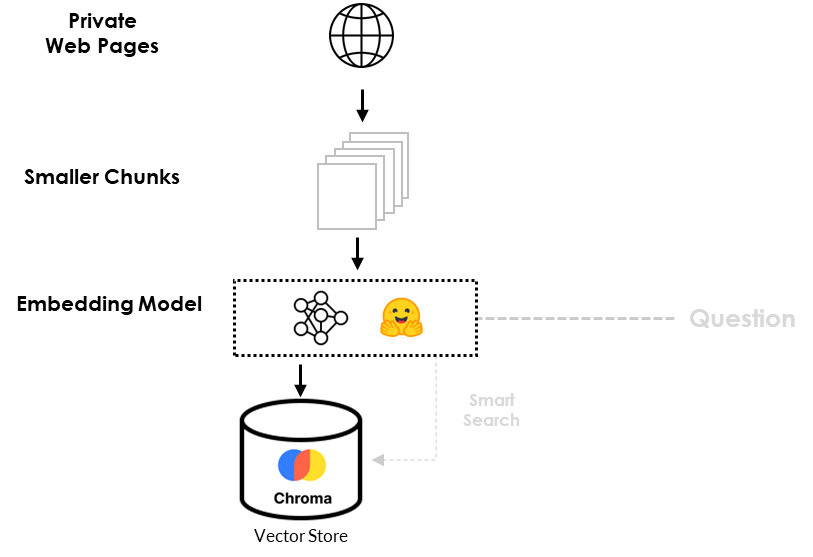

为了准确回答我们之前的问题（What is Hiberus GenIA Ecosystem?），我们必须将LLM与GenIA生态系统的信息联系起来。很幸运！有两个网页是理解GenIA生态系统的关键。

In [10]:
urls = [
    "https://www.hiberus.com/expertos-ia-generativa-ld",
    "https://www.hiberus.com/en/experts-generative-ai-ld"
]

loader = UnstructuredURLLoader(urls=urls)
documents = loader.load()

len(documents)
# Output

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


2

由于这两个文档数据量较大，以及超过了Mistral-7b大模型的上下文窗口大小，因此我们需要将文档按照1024个tokens大小进行切分，生成21个较小的chunks，并且为了保证上下文的连续性，chunk与chunk直接设置64个重叠tokens，代码如下：

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts_chunks = text_splitter.split_documents(documents)

len(texts_chunks)

22

# 八、数据注入

对数据分块之后，我们将对分块数据进行embedding并存储到向量数据库Chromdb中

In [12]:
db = Chroma.from_documents(texts_chunks, embeddings, persist_directory="db")

数据被添加索引之后，我们可以在Prompt模板中添加RAG模型赋予营销经理专家的角色！

此外，为了将LLM与矢量数据库检索功能相结合，我们使用了关键的链接组件RetrievalQA，其中k=2。这种设置确保检索器输出两个相关的块，然后LLM在提出问题时使用这两个块来制定答案。

In [13]:
template = """
[INST] <>
Act as an Hiberus marketing manager expert. Use the following information to answer the question at the end.
<>

{context}

{question} [/INST]
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

# 九、查询

执行完上述步骤，我们就可以进行查询了。

例子一：

In [14]:
query = "What is GenAI Ecosystem?"
result_ = qa_chain(
    query
)
result = result_["result"].strip()


display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>What is GenAI Ecosystem?</b>

<p>GenIA Ecosystem is an integrated set of technologies, tools, services, and resources that allows businesses to harness the power of generative AI for content generation, AI-assisted design, process optimization, or automated decision making. It offers various solutions such as h-smart Conversational, which helps develop and implement custom chatbots with advanced natural language processing and generation capabilities, as well as security protocols to ensure the protection of interactions; h-complex Data, which enables classification and extraction of data from documents, analysis of construction regulatory compliance, management of incidents, and makes personalized recommendations based on the type of user; and h-content Generation, which generates code from textual descriptions, detects offensive images or images with the potential to be offensive in e-commerce, and generates content through LLM models.</p>

例子二：

In [15]:
query = "Why Hiberus has created GenAI Ecosystem?"
result_ = qa_chain(
    query
)
result = result_["result"].strip()


display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Why Hiberus has created GenAI Ecosystem?</b>

<p>Hiberus has created GenIA Ecosystem to address the challenges faced by businesses when implementing AI technology. The ecosystem includes a range of tools, services, and resources designed to help companies harness the power of generative AI for various purposes, including content generation, AI-assisted design, process optimization, and automated decision making. By providing tailored solutions and support, training, and consulting services, Hiberus aims to help businesses overcome the lack of understanding and technical skills required to develop and maintain AI systems, as well as addressing ethical and regulatory issues related to AI.</p>

这两个问题的答案都符合预期，包括我们之前错过的那个问题。我们还可以输出LLM生成答案的源文档或参考文档。

In [16]:
result_["source_documents"]

[Document(page_content='Our team of Data and AI experts have developed GenIA Ecosystem, an ecosystem of proprietary conversational AI, content and data generation solutions adapted to the needs of each market and client. Through these solutions, we help you harness the power of generative AI to propel your business into the future.\n\nSeparador\n\nWe respond to business challenges faced with AI\n\nAt hiberus we respond to business challenges faced with AI with tailored solutions and our support and advisory, training and consulting services.\n\nLack of understanding. Companies do not know what AI is and how they can implement it in their operations. The technical skills to develop and maintain AI systems are scarce.\n\nEthics and regulation. AI raises ethical and regulatory issues, such as liability for decisions made by AI systems, bias in AI algorithms, and data privacy and protection.', metadata={'source': 'https://www.hiberus.com/en/experts-generative-ai-ld'}),
 Document(page_conte

# 十、问答

为了实现问答功能，我们首先对Prompt模板进行一些调整。然后，我们使用ConversationBufferMemory将对话存储在内存中，然后稍后检索消息。最后，使用链接组件ConversationalRetrievalChain将我们的LLM Mistral-7b与矢量数据库和聊天历史相结合。问答系统整体架构，如下图所示：

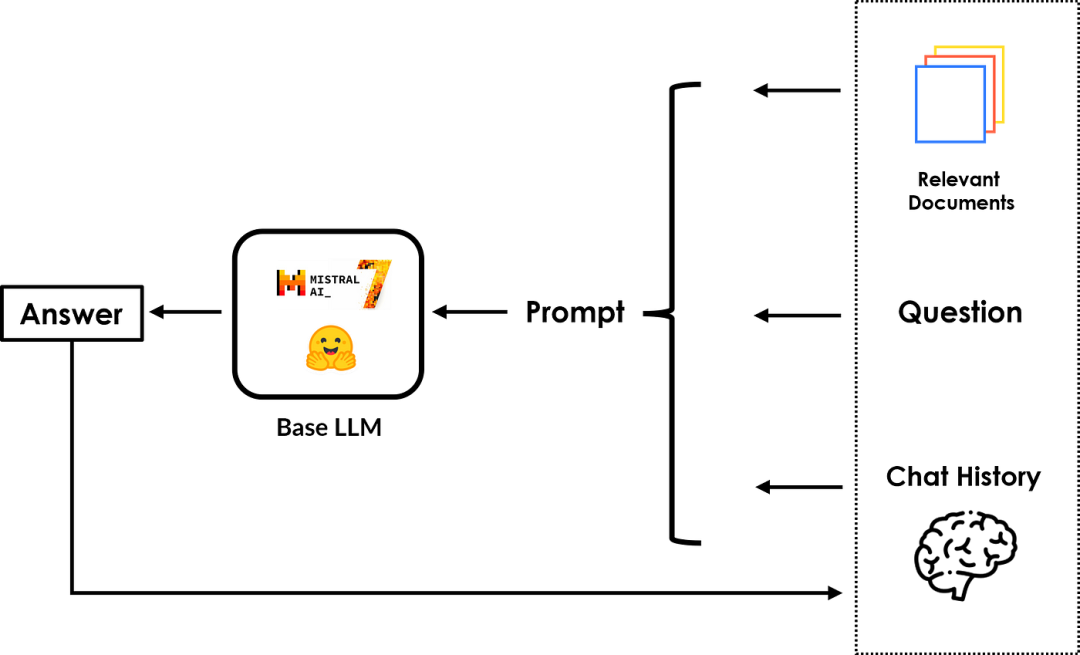

In [17]:
custom_template = """You are an Hiberus Marketing Manager AI Assistant. Given the
following conversation and a follow up question, rephrase the follow up question
to be a standalone question. At the end of standalone question add this
'Answer the question in English language.' If you do not know the answer reply with 'I am sorry, I dont have enough information'.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:
"""

CUSTOM_QUESTION_PROMPT = PromptTemplate.from_template(custom_template)

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    memory=memory,
    condense_question_prompt=CUSTOM_QUESTION_PROMPT,
)

我们来测试一下问答功能：

In [18]:
query = "Who you are?"
result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Who you are?</b>

<p>We are a technology company that advances quickly by incorporating the latest technological solutions to meet new market needs. Our team consists of more than 25 experts in generative AI with over 12,000 hours invested in research, training and projects related to generative AI in 2023. We have extensive knowledge and expertise in various markets, which allows us to offer customized solutions for each one of them. As providers of global technology with a large technological capacity and our own ecosystem of generative AI solutions, we are prepared to provide every business with the solution it needs. We are partners of leading companies in the data and artificial intelligence sectors such as Microsoft, Azure, Google and AWS. We offer support and training services to help businesses take full advantage of generative AI and gain a competitive edge in their industry with valuable services like support, advice and training.</p>

In [19]:
query = "What is GenIA Ecosystem?"

result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>What is GenIA Ecosystem?</b>

<p>GenIA Ecosystem is an integrated set of technologies, tools, services and resources that allow you to harness the power of generative AI for content generation, AI-assisted design, process optimization or automated decision making.</p>

我们可以通过查看HumanMessages中的问题和AIMessages中的模型响应来获取聊天的历史记录。

In [20]:
memory.chat_memory.messages

[HumanMessage(content='Who you are?'),
 AIMessage(content=' We are a technology company that advances quickly by incorporating the latest technological solutions to meet new market needs. Our team consists of more than 25 experts in generative AI with over 12,000 hours invested in research, training and projects related to generative AI in 2023. We have extensive knowledge and expertise in various markets, which allows us to offer customized solutions for each one of them. As providers of global technology with a large technological capacity and our own ecosystem of generative AI solutions, we are prepared to provide every business with the solution it needs. We are partners of leading companies in the data and artificial intelligence sectors such as Microsoft, Azure, Google and AWS. We offer support and training services to help businesses take full advantage of generative AI and gain a competitive edge in their industry with valuable services like support, advice and training.'),
 Hu

# 十一、基于Gradio搭建问答UI界面

Gradio具有用户友好的网络界面，任何人都可以从任何地方访问！它的工作原理如下：我们设置了一个名为querying()的函数，它将查询作为主要输入，并使用一个名为history的名称巧妙的假参数来解决一个小问题。当你启动这个函数时，它会返回我们的超级明星模型Mistral-7b生成的响应。

In [21]:
def querying(query, history):
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

  qa_chain = ConversationalRetrievalChain.from_llm(
      llm=llm,
      retriever=db.as_retriever(search_kwargs={"k": 2}),
      memory=memory,
      condense_question_prompt=CUSTOM_QUESTION_PROMPT,
  )

  result = qa_chain({"question": query})
  return result["answer"].strip()

启动Gradio聊天界面

In [22]:

iface = gr.ChatInterface(
    fn = querying,
    chatbot=gr.Chatbot(height=600),
    textbox=gr.Textbox(placeholder="What is GenAI Ecosystem?", container=False, scale=7),
    title="HiberusBot",
    theme="soft",
    examples=["Why Hiberus has created GenAI Ecosystem?",
              "What is GenAI Ecosystem?"],

    cache_examples=True,
    retry_btn="Repetir",
    undo_btn="Deshacer",
    clear_btn="Borrar",
    submit_btn="Enviar"

    )

iface.launch(share=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Caching examples at: '/content/gradio_cached_examples/15'
Caching example 1/2


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Caching example 2/2
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://8d700720ae0ef2d5c5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
